In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.stats import zscore
import pandas as pd
import os

## DETECT ARTIFACT Z-SCORE INTRAVOLUME (DONT CARE)

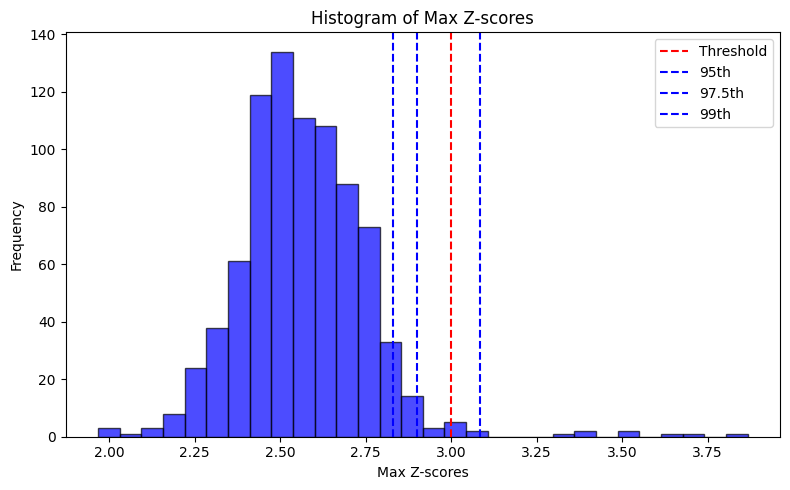

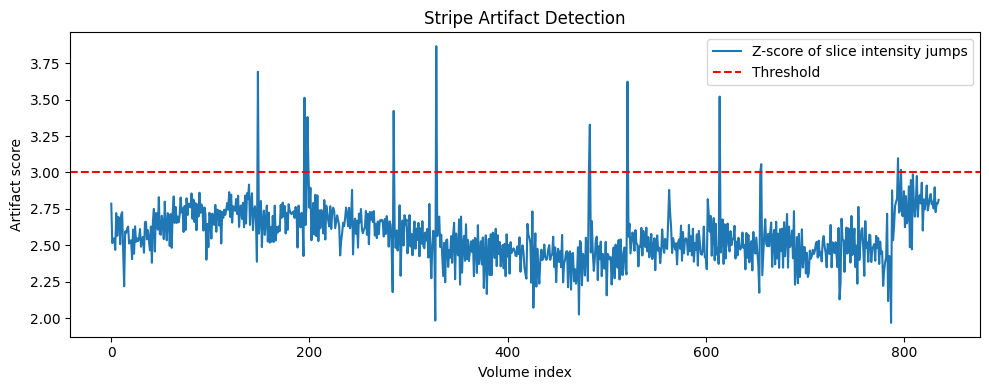

Detected artifact volumes: [148, 195, 198, 199, 285, 328, 483, 521, 614, 655, 656, 794, 797]


In [17]:
def detect_stripe_artifacts(file_path, threshold=3.0):
    # Load fMRI data
    img = nib.load(file_path)
    data = img.get_fdata()
    
    n_volumes = data.shape[-1]


    # Container for artifact scores
    artifact_scores = []

    for vol in range(n_volumes):
        volume_data = data[..., vol]
        slice_means = volume_data.mean(axis=(0, 1))  # mean over x, y for each axial slice
        diffs = np.abs(np.diff(slice_means))
        z_diffs = zscore(diffs)  # normalize diffs to detect outliers
        max_z = np.max(z_diffs)
        artifact_scores.append(max_z)

    # Threshold for outliers
    artifact_scores = np.array(artifact_scores)
    bad_volumes = np.where(artifact_scores > threshold)[0]
    
    # Plot histogram of max z-scores
    plt.figure(figsize=(8, 5))
    plt.hist(artifact_scores, bins=30, color='blue', alpha=0.7, edgecolor='black')
    plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
    plt.axvline(np.percentile(artifact_scores, 95), color='blue', linestyle='--', label='95th')
    plt.axvline(np.percentile(artifact_scores, 97.5), color='blue', linestyle='--', label='97.5th')
    plt.axvline(np.percentile(artifact_scores, 99), color='blue', linestyle='--', label='99th')
    plt.xlabel("Max Z-scores")
    plt.ylabel("Frequency")
    plt.title("Histogram of Max Z-scores")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return bad_volumes, artifact_scores

# Example usage
file_path = r"C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\artif_01_bold.nii.gz"
bad_vols, scores = detect_stripe_artifacts(file_path)

# Save results
# df = pd.DataFrame({"Volume": list(range(len(scores))), "ArtifactScore": scores})
# df["IsArtifact"] = df["ArtifactScore"] > 3.0
# df.to_csv("artifact_detection_results.csv", index=False)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(scores, label="Z-score of slice intensity jumps")
plt.axhline(3.0, color='red', linestyle='--', label='Threshold')
plt.xlabel("Volume index")
plt.ylabel("Artifact score")
plt.title("Stripe Artifact Detection")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Detected artifact volumes: {bad_vols.tolist()}")


## DETECT ARTIFACT Z-SCORE CROSSVOLUME

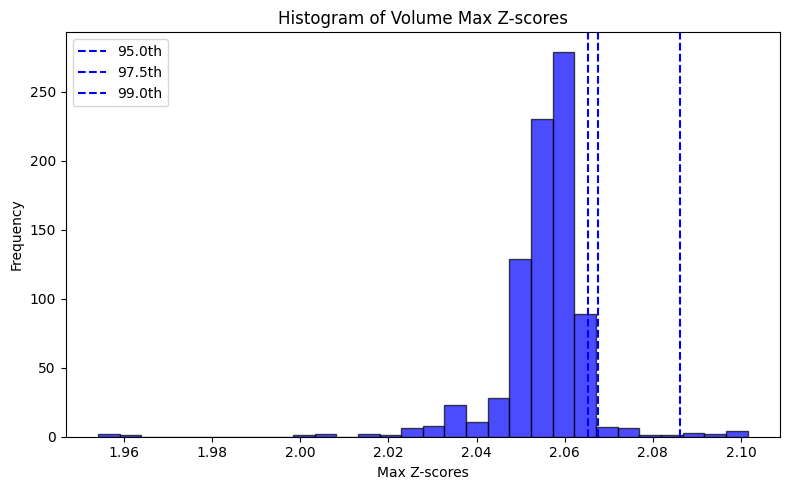

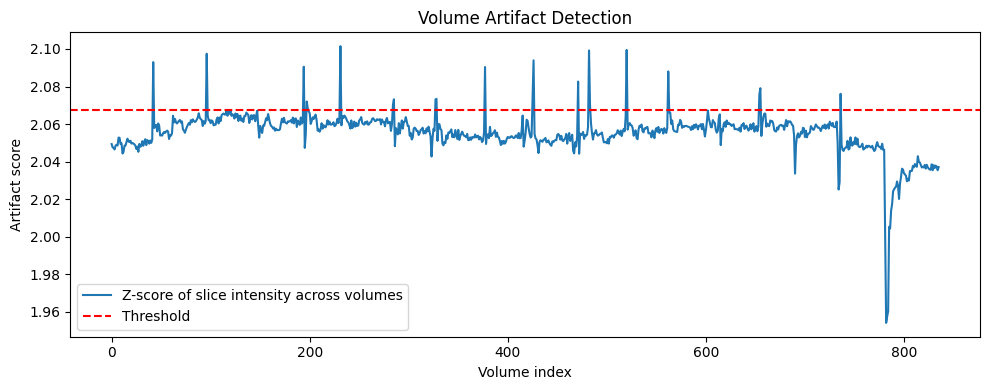

Detected artifact volumes: [42, 96, 194, 197, 198, 231, 284, 285, 327, 328, 377, 425, 426, 471, 482, 483, 520, 562, 654, 655, 736]


In [21]:
def detect_volume_artifacts(file_path, percentile=97.5):
    # Load fMRI data
    img = nib.load(file_path)
    data = img.get_fdata()
    
    n_slices = data.shape[2]
    n_volumes = data.shape[3]

    # Container for artifact scores
    volume_scores = []

    for vol in range(n_volumes):
        # Compute the mean intensity for each slice in the volume
        slice_means = data[:, :, :, vol].mean(axis=(0, 1))  # mean over x, y for each slice
        z_scores = zscore(slice_means)  # normalize slice means to detect outliers
        max_z = np.max(np.abs(z_scores))
        volume_scores.append(max_z)

    # Threshold for outliers
    volume_scores = np.array(volume_scores)
    bad_volumes = np.where(volume_scores > np.percentile(volume_scores, percentile))[0]
    
    # Plot histogram of max z-scores
    plt.figure(figsize=(8, 5))
    plt.hist(volume_scores, bins=30, color='blue', alpha=0.7, edgecolor='black')
    # plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
    plt.axvline(np.percentile(volume_scores, percentile - 2.5), color='blue', linestyle='--', label=f'{percentile - 2.5}th')
    plt.axvline(np.percentile(volume_scores, percentile), color='blue', linestyle='--', label=f'{percentile}th')
    plt.axvline(np.percentile(volume_scores, percentile + 1.5), color='blue', linestyle='--', label=f'{percentile + 1.5}th')
    plt.xlabel("Max Z-scores")
    plt.ylabel("Frequency")
    plt.title("Histogram of Volume Max Z-scores")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return bad_volumes, volume_scores

# Example usage
file_path = r"C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\artif_01_bold.nii.gz"
perc = 97.5
bad_volumes, volume_scores = detect_volume_artifacts(file_path, percentile=perc)

# Save results
# df_volumes = pd.DataFrame({"Volume": list(range(len(volume_scores))), "ArtifactScore": volume_scores})
# df_volumes["IsArtifact"] = df_volumes["ArtifactScore"] > 3.0
# df_volumes.to_csv("volume_artifact_detection_results.csv", index=False)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(volume_scores, label="Z-score of slice intensity across volumes")
plt.axhline(np.percentile(volume_scores, perc), color='red', linestyle='--', label='Threshold')
plt.xlabel("Volume index")
plt.ylabel("Artifact score")
plt.title("Volume Artifact Detection")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Detected artifact volumes: {bad_volumes.tolist()}")

## DETECT ARTIFACT Z-SCORE INTRAVOLUME WITH ADAPTATIVE THRESHOLD USING INTRA-CROSS VOLUME INFO

Adaptive intravolume threshold from clean data: 3.94
Adaptive crossvolume threshold from clean data: 2.01


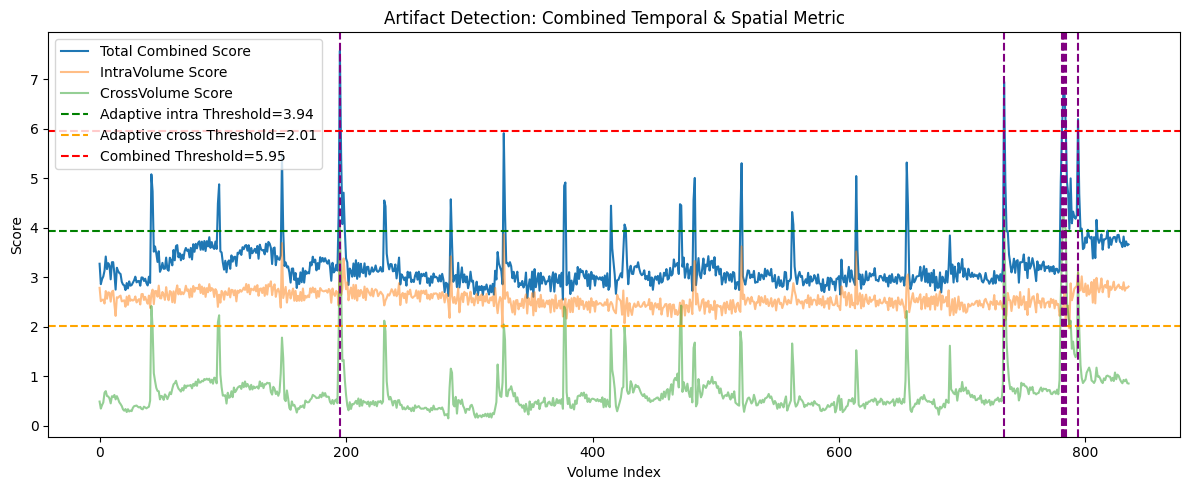

Detected artifact volumes: [195, 734, 781, 782, 783, 784, 794]


In [9]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
from scipy.stats import zscore
import glob
import matplotlib.pyplot as plt

def load_fmri_data(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

def compute_intravolume_scores(data):
    """For each volume, compute max z-score of slice-to-slice diff."""
    scores = []
    for v in range(data.shape[3]):
        vol = data[..., v]
        slice_means = vol.mean(axis=(0, 1))  # mean per axial slice
        diffs = np.abs(np.diff(slice_means))
        z_diffs = zscore(diffs)
        scores.append(np.max(z_diffs))
    return np.array(scores)

def compute_crossvolume_scores(data):
    """Compute slice-wise temporal z-score consistency for each volume."""
    z_dim = data.shape[2]
    t_dim = data.shape[3]
    cross_scores = np.zeros(t_dim)
    
    for z in range(z_dim):
        time_series = data[:, :, z, :].mean(axis=(0, 1))  # shape: (t,)
        z_scores = zscore(time_series)
        cross_scores += np.abs(z_scores)  # accumulate deviation
    
    return cross_scores / z_dim  # average deviation per volume

def get_adaptive_threshold(file_paths, compute_scores, percentile=99.5):
    all_scores = []
    for f in file_paths:
        data = load_fmri_data(f)
        scores = compute_scores(data)
        all_scores.extend(scores)
    threshold = np.percentile(all_scores, percentile)
    return threshold

def detect_artifacts(file_path, adaptive_threshold, cross_threshold):
    data = load_fmri_data(file_path)
    intra_scores = compute_intravolume_scores(data)
    cross_scores = compute_crossvolume_scores(data)

    # Combine both
    combined_score = intra_scores + cross_scores

    artifact_vols = np.where(combined_score > adaptive_threshold + cross_threshold)[0]
    return artifact_vols, intra_scores, cross_scores

# ---- RUNNING PIPELINE ----

folder_path = r'C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data'

# Collect paths
clean_paths = glob.glob(os.path.join(folder_path, "clean_*.nii.gz"))
artif_paths = glob.glob(os.path.join(folder_path, "artif_*.nii.gz"))
medium_paths = glob.glob(os.path.join(folder_path, "medium_*.nii.gz"))

# 1) Adaptive threshold learning
adaptive_intra_thresh = get_adaptive_threshold(clean_paths, compute_intravolume_scores, percentile=99.5)
print(f"Adaptive intravolume threshold from clean data: {adaptive_intra_thresh:.2f}")

adaptive_cross_thresh = get_adaptive_threshold(clean_paths, compute_crossvolume_scores, percentile=99.5)
print(f"Adaptive crossvolume threshold from clean data: {adaptive_cross_thresh:.2f}")

# 2) Detect artifacts on one sample
target_file = artif_paths[0]  # change index if needed
bad_volumes, intra_scores, cross_scores = detect_artifacts(target_file, adaptive_intra_thresh, adaptive_cross_thresh)

# Save results
# df = pd.DataFrame({
#     "Volume": np.arange(len(intra_scores)),
#     "IntraVolumeScore": intra_scores,
#     "CrossVolumeScore": cross_scores,
#     "TotalScore": intra_scores + cross_scores,
# })
# df["IsArtifact"] = df["TotalScore"] > (adaptive_intra_thresh + 2.5)
# df.to_csv("artifact_detection_combined.csv", index=False)

# Visualize
plt.figure(figsize=(12, 5))
plt.plot(df["TotalScore"], label="Total Combined Score")
plt.plot(df["IntraVolumeScore"], label="IntraVolume Score", alpha=0.5)
plt.plot(df["CrossVolumeScore"], label="CrossVolume Score", alpha=0.5)
plt.axhline(adaptive_intra_thresh, color='green', linestyle='--', label=f'Adaptive intra Threshold={adaptive_intra_thresh:.2f}')
plt.axhline(adaptive_cross_thresh, color='orange', linestyle='--', label=f'Adaptive cross Threshold={adaptive_cross_thresh:.2f}')
plt.axhline(adaptive_intra_thresh + adaptive_cross_thresh, color='red', linestyle='--', label=f'Combined Threshold={adaptive_intra_thresh + adaptive_cross_thresh:.2f}')
for volume in bad_volumes:
    plt.axvline(volume, color='purple', linestyle='--', label='')
plt.xlabel("Volume Index")
plt.ylabel("Score")
plt.title("Artifact Detection: Combined Temporal & Spatial Metric")
plt.legend()
plt.tight_layout()
plt.show()

print("Detected artifact volumes:", bad_volumes.tolist())

## CROSS VALIDATION AND WEIGHTED SCORE /!\ DONT WORK WELL

Learning adaptive threshold from clean data...
Adaptive intra-volume threshold: 3.94
Tuning offset using medium data...
Best offset learned: 2.11


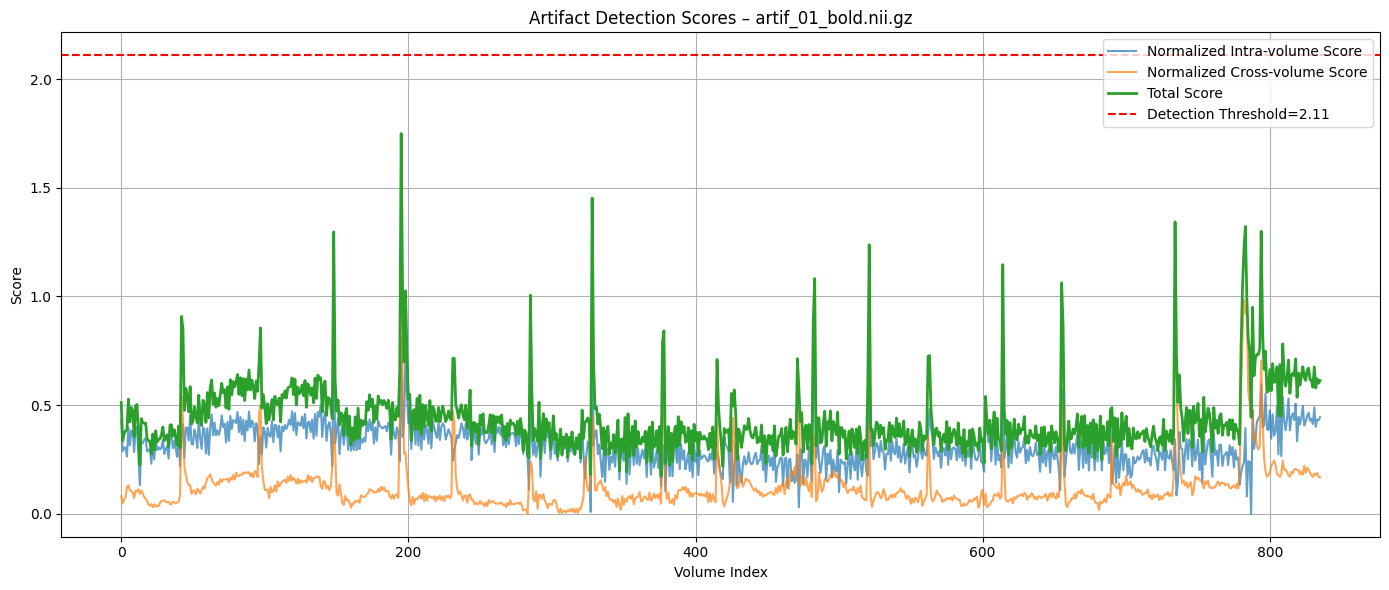

Detected volumes: []


In [27]:
import os
import glob
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.metrics import f1_score

# --- CORE FUNCTIONS --- #

def load_fmri_data(path):
    return nib.load(path).get_fdata()

def compute_intra_scores(data):
    scores = []
    for v in range(data.shape[3]):
        vol = data[..., v]
        slice_means = vol.mean(axis=(0, 1))
        diffs = np.abs(np.diff(slice_means))
        z_diffs = zscore(diffs)
        scores.append(np.max(z_diffs))
    return np.array(scores)

def compute_cross_scores(data):
    z_dim, t_dim = data.shape[2], data.shape[3]
    scores = np.zeros(t_dim)
    for z in range(z_dim):
        ts = data[:, :, z, :].mean(axis=(0, 1))
        scores += np.abs(zscore(ts))
    return scores / z_dim

def normalize_scores(scores):
    return (scores - np.min(scores)) / (np.max(scores) - np.min(scores) + 1e-8)

# --- ADAPTIVE THRESHOLD --- #

def learn_threshold(clean_paths, percentile=99.5):
    all_scores = []
    for f in clean_paths:
        data = load_fmri_data(f)
        all_scores.extend(compute_intra_scores(data))
    return np.percentile(all_scores, percentile)

# --- CROSS-VALIDATE OFFSET --- #

def cross_validate_offset(adaptive_thresh, medium_paths, offsets=np.linspace(0, 4, 20)):
    best_f1, best_offset = 0, 0
    for offset in offsets:
        preds, targets = [], []
        for f in medium_paths:
            data = load_fmri_data(f)
            intra = compute_intra_scores(data)
            cross = compute_cross_scores(data)

            intra_norm = normalize_scores(intra)
            cross_norm = normalize_scores(cross)
            total_score = intra_norm + cross_norm

            threshold = normalize_scores(np.array([adaptive_thresh]))[0] + offset
            pred = (total_score > threshold).astype(int)
            target = np.zeros_like(pred)  # Assume medium data has no true artifacts
            f1 = f1_score(target, pred, zero_division=1)

            preds.extend(pred)
            targets.extend(target)

        avg_f1 = f1_score(targets, preds, zero_division=1)
        if avg_f1 > best_f1:
            best_f1, best_offset = avg_f1, offset
    return best_offset

# --- ARTIFACT DETECTION --- #

def detect_artifacts(path, adaptive_thresh, offset):
    data = load_fmri_data(path)
    intra = compute_intra_scores(data)
    cross = compute_cross_scores(data)

    intra_norm = normalize_scores(intra)
    cross_norm = normalize_scores(cross)
    total_score = intra_norm + cross_norm
    threshold = normalize_scores(np.array([adaptive_thresh]))[0] + offset
    detected = np.where(total_score > threshold)[0]

    return detected, intra_norm, cross_norm, total_score, threshold

# --- PLOTTING --- #

def plot_scores(intra, cross, total, threshold, detected, title):
    x = np.arange(len(intra))
    plt.figure(figsize=(14, 6))

    plt.plot(x, intra, label="Normalized Intra-volume Score", alpha=0.7)
    plt.plot(x, cross, label="Normalized Cross-volume Score", alpha=0.7)
    plt.plot(x, total, label="Total Score", linewidth=2)

    plt.axhline(threshold, color='red', linestyle='--', label=f'Detection Threshold={threshold:.2f}')

    for vol in detected:
        plt.axvline(vol, color='orange', linestyle=':', alpha=0.5)

    plt.title(f"Artifact Detection Scores – {title}")
    plt.xlabel("Volume Index")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- EXECUTION --- #

folder_path = r'C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data'
clean_paths = glob.glob(os.path.join(folder_path, "clean_*.nii.gz"))
medium_paths = glob.glob(os.path.join(folder_path, "medium_*.nii.gz"))
artif_paths = glob.glob(os.path.join(folder_path, "artif_*.nii.gz"))

print("Learning adaptive threshold from clean data...")
# adaptive_thresh = learn_threshold(clean_paths)
adaptive_thresh = 3.94
print(f"Adaptive intra-volume threshold: {adaptive_thresh:.2f}")

print("Tuning offset using medium data...")
# best_offset = cross_validate_offset(adaptive_thresh, medium_paths)
best_offset = 2.11
print(f"Best offset learned: {best_offset:.2f}")

# --- RUN ON ARTIFACT DATASET --- #
target_file = artif_paths[0]  # Adjust as needed
detected, intra_norm, cross_norm, total_score, thresh = detect_artifacts(target_file, adaptive_thresh, best_offset)

# Save & plot
vol_df = pd.DataFrame({
    "Volume": np.arange(len(intra_norm)),
    "IntraScore": intra_norm,
    "CrossScore": cross_norm,
    "TotalScore": total_score,
})
vol_df["IsArtifact"] = vol_df["TotalScore"] > thresh
vol_df.to_csv("final_artifact_results.csv", index=False)

plot_scores(intra_norm, cross_norm, total_score, thresh, detected, os.path.basename(target_file))
print("Detected volumes:", detected.tolist())


Best cross-weight: 0.0 → TP: 61, FP: 5


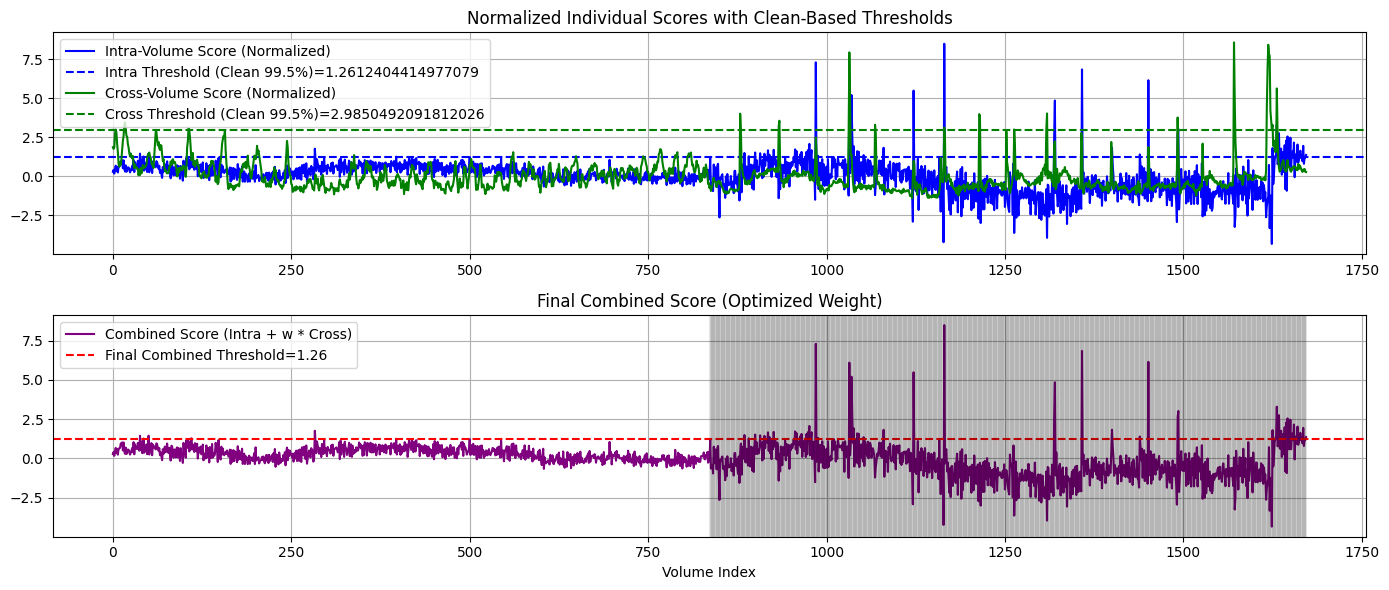

In [26]:
import os
import glob
import numpy as np
import nibabel as nib
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt

def load_fmri_data(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

def compute_intravolume_scores(data):
    scores = []
    for v in range(data.shape[3]):
        vol = data[..., v]
        slice_means = vol.mean(axis=(0, 1))
        diffs = np.abs(np.diff(slice_means))
        z_diffs = zscore(diffs)
        scores.append(np.max(z_diffs))
    return np.array(scores)

def compute_crossvolume_scores(data):
    z_dim, t_dim = data.shape[2], data.shape[3]
    cross_scores = np.zeros(t_dim)
    for z in range(z_dim):
        time_series = data[:, :, z, :].mean(axis=(0, 1))  # shape (t,)
        z_scores = zscore(time_series)
        cross_scores += np.abs(z_scores)
    return cross_scores / z_dim

def normalize_scores(scores):
    return (scores - np.mean(scores)) / np.std(scores)

def get_adaptive_threshold(file_paths, percentile=99.5):
    all_scores = []
    for f in file_paths:
        data = load_fmri_data(f)
        scores = compute_intravolume_scores(data)
        all_scores.extend(scores)
    return np.percentile(all_scores, percentile)

def evaluate_combination(intra, cross, true_artifacts, clean_len, cross_weight=1.0, intra_thresh=None):
    intra_norm = normalize_scores(intra)
    cross_norm = normalize_scores(cross)
    combined = intra_norm + cross_weight * cross_norm

    # Auto threshold from clean only scores
    if intra_thresh is None:
        intra_thresh = np.percentile(intra_norm[:clean_len], 99.5)
    threshold = intra_thresh

    pred = combined > threshold
    TP = sum(pred[true_artifacts])
    FP = sum(pred[:clean_len])  # false positives in clean
    return TP, FP, threshold, combined

def tune_cross_weight(clean_data, artifact_data, max_weight=3.0, step=0.25):
    clean_scores = compute_intravolume_scores(clean_data)
    cross_clean_scores = compute_crossvolume_scores(clean_data)
    artif_scores = compute_intravolume_scores(artifact_data)
    cross_artif_scores = compute_crossvolume_scores(artifact_data)

    all_intra = np.concatenate([clean_scores, artif_scores])
    all_cross = np.concatenate([cross_clean_scores, cross_artif_scores])
    true_artifacts = np.arange(len(clean_scores), len(clean_scores) + len(artif_scores))

    best_metric = -np.inf
    best_weight = 0
    best_results = None

    for w in np.arange(0, max_weight + step, step):
        TP, FP, thresh, combined = evaluate_combination(all_intra, all_cross, true_artifacts, len(clean_scores), w)
        metric = TP - FP  # crude but effective
        if metric > best_metric:
            best_metric = metric
            best_weight = w
            best_results = (combined, thresh, TP, FP)

    print(f"Best cross-weight: {best_weight} → TP: {best_results[2]}, FP: {best_results[3]}")
    return best_weight, best_results

# -------- Run Full Pipeline --------

folder_path = r'C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data'
clean_paths = glob.glob(os.path.join(folder_path, "clean_*.nii.gz"))
artif_paths = glob.glob(os.path.join(folder_path, "artif_*.nii.gz"))

# Pick 1 clean and 1 artifact file for tuning
clean_file = clean_paths[0]
artifact_file = artif_paths[0]

clean_data = load_fmri_data(clean_file)
artifact_data = load_fmri_data(artifact_file)

# Cross-validation to tune combination weight
best_weight, (combined_score, adaptive_thresh, TP, FP) = tune_cross_weight(clean_data, artifact_data)

# Final detection and visualization
intra = np.concatenate([compute_intravolume_scores(clean_data), compute_intravolume_scores(artifact_data)])
cross = np.concatenate([compute_crossvolume_scores(clean_data), compute_crossvolume_scores(artifact_data)])
intra_norm = normalize_scores(intra)
cross_norm = normalize_scores(cross)

volumes = np.arange(len(combined_score))
labels = np.array(["Clean"] * clean_data.shape[3] + ["Artifact"] * artifact_data.shape[3])

# ----- PLOT -----
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(volumes, intra_norm, label='Intra-Volume Score (Normalized)', color='blue')
plt.axhline(np.percentile(intra_norm[:clean_data.shape[3]], 99.5), color='blue', linestyle='--', label=f'Intra Threshold (Clean 99.5%)={np.percentile(intra_norm[:clean_data.shape[3]], 99.5)}')

plt.plot(volumes, cross_norm, label='Cross-Volume Score (Normalized)', color='green')
plt.axhline(np.percentile(cross_norm[:clean_data.shape[3]], 99.5), color='green', linestyle='--', label=f'Cross Threshold (Clean 99.5%)={np.percentile(cross_norm[:clean_data.shape[3]], 99.5)}')
plt.title("Normalized Individual Scores with Clean-Based Thresholds")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(volumes, combined_score, label='Combined Score (Intra + w * Cross)', color='purple')
plt.axhline(adaptive_thresh, color='red', linestyle='--', label=f'Final Combined Threshold={adaptive_thresh:.2f}')
for i in np.where(labels == "Artifact")[0]:
    plt.axvline(i, color='black', alpha=0.1)
plt.title("Final Combined Score (Optimized Weight)")
plt.xlabel("Volume Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()